## Imports

In [270]:
import itertools
import math
import nltk
from collections import Counter

from time import sleep
from selenium import webdriver
from bs4 import BeautifulSoup

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score
from sklearn.metrics import classification_report
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.inspection import permutation_importance
from sklearn.feature_extraction.text import TfidfVectorizer
from xgboost import XGBClassifier

from prettytable import PrettyTable
from pprint import *

nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/runlanlana/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


## Initial Observations

In [92]:
adidas = pd.read_csv("data/adidas_merged_cleaned.csv", index_col = 0)

print("Basic information about our Adidas' footwear dataset:\n")
print(adidas.info())
print(adidas.describe())
display(adidas.head(3))

Basic information about our Adidas' footwear dataset:

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2390 entries, 0 to 2389
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   title          2389 non-null   object 
 1   subtitle       2360 non-null   object 
 2   num_colors     2390 non-null   object 
 3   url            2390 non-null   object 
 4   price          2386 non-null   object 
 5   reduced_price  2246 non-null   object 
 6   description    2368 non-null   object 
 7   details        2248 non-null   object 
 8   colors         1945 non-null   object 
 9   n_reviews      2180 non-null   float64
 10  avg_stars      2180 non-null   float64
 11  product_code   2390 non-null   object 
dtypes: float64(2), object(10)
memory usage: 242.7+ KB
None
          n_reviews    avg_stars
count   2180.000000  2180.000000
mean     841.304128     4.578578
std     2402.486479     0.361305
min        1.000000     1.0000

,title,subtitle,num_colors,url,price,reduced_price,description,details,colors,n_reviews,avg_stars,product_code
0,Start Your Run Shoes,Women's Running,4 colors,/us/start-your-run-shoes/GY9233.html,$65,$33,You'll want these adidas running shoes the nex...,Regular fit; Lace closure; Textile upper; LIGH...,Dash Grey / Matte Silver / Core Black,5.0,4.8,GY9233
1,NMD_R1 Shoes,Youth Originals,1,/us/nmd_r1-shoes/H03994.html,$130,$91,"One shoe to rule them all. School, work or kic...",Regular fit; Lace closure; Mesh upper; Boost m...,NaN,131.0,4.6,H03994
2,Edge Lux Shoes,Women's Training,5 colors,/us/edge-lux-shoes/GZ6741.html,$90,$45,"Comfort is key, whether you're racing to catch...",Women's-specific fit; Lace closure; Textile up...,Core Black / Core Black / Iron Metallic,191.0,4.0,GZ6741


## Missing Data

In [93]:
# number of missing values in each column
adidas.isna().sum()

title              1
subtitle          30
num_colors         0
url                0
price              4
reduced_price    144
description       22
details          142
colors           445
n_reviews        210
avg_stars        210
product_code       0
dtype: int64

### Filling missing price entries

In [94]:
def get_title(page):
    title = page.find(attrs = {"data-testid": "product-title"})
    if title is None:
        return None
    return title.text

def get_subtitle(page):
    subtitle = page.find(attrs = {"data-auto-id": "product-category"})
    if subtitle is None:
        return None
    return subtitle.text
                               
def get_price(page):
    pricetag = page.select(".product-description___1TLpA .product-price___2Mip5 .price-wrapper___2Pj9R .gl-price .gl-price-item")
    return [p.text for p in pricetag] # usually starts with [original, sale]
    # may need to double check the order
    
def get_description(page):
    # some shoes don't have description
    description = page.select_one("#navigation-target-description .gl-accordion__content p")
    if description is None:
        return None
    return description.text

def get_details(page):
    details = page.select_one("#navigation-target-specifications .gl-accordion__content")
    if details is None:
        return None
    bullets = [x.select(".gl-vspace-bpall-small") for x in details.select(".gl-list")]
    bullet_text = [x_sub.text for x in bullets for x_sub in x]
    return "; ".join(bullet_text)    
    
def get_reviews(page):
    review_section = page.select_one("#navigation-target-reviews")
    if review_section is None:
        return None, None
    review_title = review_section.select_one('.gl-accordion__header .gl-accordion__title')
    if review_title:
        review_title = review_title.text
        n_reviews = review_title[review_title.index('(') + 1 : review_title.index(')')]
        avg_stars = review_section.find(attrs = {'data-auto-id': 
                                    'ratings-reviews'})
        if avg_stars:
            avg_stars = avg_stars.select_one('.out-of-5___i5A3q')
        if avg_stars:
            return n_reviews, avg_stars.text
        else:
            return n_reviews, None
    else:
        return None, None
                               
def get_page(url):
    driver = webdriver.Chrome()
    driver.get(url)
    sleep(1)
    soup = BeautifulSoup(driver.page_source, "html.parser")
    driver.close()
    return soup

def fill_na(row):
    if "adidas.com" not in row['url']:
        full_url = 'https://www.adidas.com' + row['url']
    else:
        full_url = row['url']
    soup = get_page(full_url)
    title = get_title(soup) if pd.isna(row['title']) else None
    subtitle = get_subtitle(soup) if pd.isna(row['subtitle']) else None
    price = get_price(soup)
    description = ge
    n_reviews, avg_stars = get_reviews(soup)
    return title, subtitle, price, n_reviews, avg_stars

# price_na = adidas.loc[adidas['price'].isna()]

# for index, row in price_na.iterrows():
#     title, subtitle, price, n_reviews, avg_stars = fill_na(row)
#     print("Filling obs:", title, subtitle, price, n_reviews, avg_stars)
#     if title is not None:
#         adidas.loc[index, 'title'] = title
#     if subtitle is not None:
#         adidas.loc[index, 'subtitle'] = subtitle
#     adidas.loc[index, 'price'] = int(price[0].replace("$", ""))
#     adidas.loc[index, 'reduced_price'] = int(price[1].replace("$", ""))
#     adidas.loc[index, 'n_reviews'] = n_reviews
#     adidas.loc[index, 'avg_stars'] = avg_stars

In [103]:
# rows_na = adidas[['price', 'subtitle', 'reviews', 'descriptions', 'details']].loc[adidas['subtitle'].isna()]
fill_cols = ['price', 'subtitle', 'n_reviews', 'description', 'details']
rows_na = adidas.loc[pd.isnull(adidas[fill_cols]).any(1), :].index.values

for index, row in adidas.loc[rows_na].iterrows():
    if "adidas.com" not in row['url']:
        full_url = 'https://www.adidas.com' + row['url']
    else:
        full_url = row['url']
    soup = get_page(full_url)
    if pd.isna(row['title']):
        adidas.loc[index, 'title'] = get_title(soup)
    if pd.isna(row['subtitle']):
        adidas.loc[index, 'subtitle'] = get_subtitle(soup)
    if pd.isna(row['price']):
        price_list = get_price(soup)
        adidas.loc[index, 'price'] = int(price_list[0].replace("$", ""))
        adidas.loc[index, 'reduced_price'] = int(price_list[1].replace("$", ""))
    if pd.isna(row['description']):
        adidas.loc[index, 'description'] = get_description(soup)
    if pd.isna(row['details']):
        adidas.loc[index, 'details'] = get_details(soup)
    if pd.isna(row['n_reviews']):
        n_reviews, avg_stars = get_reviews(soup)
        adidas.loc[index, 'n_reviews'] = n_reviews
        adidas.loc[index, 'avg_stars'] = avg_stars

In [106]:
adidas.isna().sum()

title              0
subtitle          29
num_colors         0
url                0
price              0
reduced_price    140
description       22
details            0
colors           445
n_reviews        138
avg_stars        138
product_code       0
dtype: int64

In [107]:
# remove $ and convert price to float
adidas['price'] = adidas['price'].str.replace("$",'').str.replace(',','').astype(np.float64)

/var/folders/kl/zzq83xsx65s2p501hz1mwvlw0000gn/T/ipykernel_4249/3618100312.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  adidas['price'] = adidas['price'].str.replace("$",'').str.replace(',','').astype(np.float64)


**Filling the rest of missing entries for `n_reviews` and `avg_stars` with zeros**

In [108]:
adidas['n_reviews'].fillna(0, inplace = True)
adidas['avg_stars'].fillna(0, inplace = True)

**Truncate `num_colors` to only numeric**

In [109]:
adidas['num_colors'] = adidas['num_colors'].str.extract('(\d+)').astype(np.float64)

In [110]:
adidas.to_csv("data/adidas_merged_cleaned2.csv")

# Import cleaned dataset

In [139]:
adidas = pd.read_csv("data/adidas_merged_cleaned2.csv", index_col = 0)
display(adidas.head(2))

,title,subtitle,num_colors,url,price,reduced_price,description,details,colors,n_reviews,avg_stars,product_code
0,Start Your Run Shoes,Women's Running,4.0,/us/start-your-run-shoes/GY9233.html,65.0,$33,You'll want these adidas running shoes the nex...,Regular fit; Lace closure; Textile upper; LIGH...,Dash Grey / Matte Silver / Core Black,5.0,4.8,GY9233
1,NMD_R1 Shoes,Youth Originals,1.0,/us/nmd_r1-shoes/H03994.html,130.0,$91,"One shoe to rule them all. School, work or kic...",Regular fit; Lace closure; Mesh upper; Boost m...,NaN,131.0,4.6,H03994


## Preprocess `subtitle` feature

* break into two parts: `category` and `purpose`
* `category`: Men's, Women's, Kids, Infant
* `purpose`: Lifestyle, Running, Basketball, etc.

In [140]:
pprint(list(adidas['subtitle'].unique()))

["Women's Running",
 'Youth Originals',
 "Women's Training",
 'Sportswear',
 "Men's Sportswear",
 "Men's Essentials",
 "Women's Sportswear",
 "Women's Originals",
 "Women's • Essentials",
 "Women's • Originals",
 "Women's • Running",
 "Women's • Sportswear",
 "Men's • Essentials",
 'Originals',
 "Men's • Running",
 "Men's • Originals",
 'Kids Unisex • Originals',
 'Running',
 'Kids Unisex • Sportswear',
 'Yoga',
 'Essentials',
 "Men's • Sportswear",
 'Kids Unisex • Essentials',
 'Children Essentials',
 "Men's • TERREX",
 "Women's TERREX",
 'Basketball',
 "Men's Soccer",
 'Swim',
 "Men's TERREX",
 "Women's Essentials",
 "Men's Running",
 'Infant & Toddler Training',
 'Kids Unisex • TERREX',
 "Women's • Basketball",
 "Women's • Training",
 "Men's • Five Ten",
 'Kids Unisex • Lifestyle',
 "Women's • Swim",
 "Women's • adidas by Stella McCartney",
 'Cycling',
 "Men's • Soccer",
 "Women's • TERREX",
 'Soccer',
 "Men's Originals",
 'Children Sportswear',
 'Kids Essentials',
 'Infant & Toddle

In [141]:
adidas.loc[adidas['subtitle'].str.contains("Men's", na = False, case = True), 'category'] = "Men's"
adidas.loc[adidas['subtitle'].str.contains("Women's", na = False, case = True), 'category'] = "Women's"
adidas.loc[adidas['subtitle'].str.contains("(Kids)|(Children)|(Girls)|(Boys)|(youth)", 
                                           na = False, regex = True), 'category'] = "Kids"
adidas.loc[adidas['subtitle'].str.contains("infant", na = False, case = False), 'category'] = "Infant's"
adidas.loc[adidas['subtitle'].str.contains("toddler", na = False, case = False), 'category'] = "Infant's"
adidas['category'].fillna("Men's", inplace = True) 

/var/folders/kl/zzq83xsx65s2p501hz1mwvlw0000gn/T/ipykernel_4249/551227479.py:3: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  adidas.loc[adidas['subtitle'].str.contains("(Kids)|(Children)|(Girls)|(Boys)|(youth)",


In [173]:
adidas['purpose'] = adidas['subtitle']
adidas = adidas.replace({'purpose' : { ".*Running.*" : "Running",
                                       ".*Basketball.*" : "Basketball",
                                       ".*Baseball.*" : "Baseball",
                                       ".*Volleyball.*" : "Volleyball",
                                       ".*Hiking.*" : "Hiking",
                                       ".*TERREX.*": "Hiking",
                                       ".*HIIT.*" : "Training",
                                       ".*Skate.*" : "Skate",
                                       ".*Football.*" : "Football",
                                       ".*Boot.*" : "Boot",
                                       ".*Lacrosse.*" : "Lacrosse",
                                       ".*Cycling.*" : "Cycling",
                                       ".*Thong.*" : "Sandal",
                                       ".*Flip Flop.*" : "Sandal",
                                       "Flip-Flop" : "Sandal",
                                       ".*Sandal.*" : "Sandal",
                                       ".*Slide.*" : "Sandal",
                                       "Slip$" : "Sandal",
                                       "^Slip-On$" : "Sandal",
                                       ".*Softball.*" : "Softball",
                                       ".*Golf.*" : "Golf",
                                       ".*Soccer.*" : "Soccer",
                                       ".*Tennis.*" : "Tennis",
                                       ".*Training.*" : "Training",
                                       ".*Custom.*" : "Custom",
                                       "High Top" : "Lifestyle",
                                       ".*Lifestyle.*" : "Lifestyle",
                                       ".*Essentials.*": "Lifestyle",
                                       ".*Racing.*" : "Racing",
                                       ".*Track.*" : "Track",
                                       ".*Originals.*": "Lifestyle",
                                       ".*Boxing.*": "Boxing",
                                       ".*Sportswear.*": "Sportswear",
                                       ".*Yoga.*": "Yoga",
                                       ".*Swim.*": "Swim",
                                       ".*Five Ten.*": "Climbing & Mountain Biking"
                                      }}, regex = True)
adidas = adidas.replace({'purpose' : { "Y[-]3" : "Lifestyle",
                                      ".*adidas by Stella McCartney.*": "Lifestyle"}}, regex = True)

# adidas['subtitle'] = adidas['subtitle'].str.replace("Men's","")
# adidas['subtitle'] = adidas['subtitle'].str.replace("Women's","")
# adidas['subtitle'] = adidas['subtitle'].str.replace("• ","")
# adidas['subtitle'] = adidas['subtitle'].str.strip()
# adidas = adidas.replace({'subtitle' : { "^Shoe" : "Lifestyle Shoe"}}, regex = True)

In [174]:
unique_cat = list(adidas['category'].unique())
unique_purpose = list(adidas['purpose'].unique())

print(f"There are {len(unique_cat)} unique categories and {len(unique_purpose)} unique purposes")
print(unique_cat)
pprint(unique_purpose)

There are 4 unique categories and 21 unique purposes
["Women's", "Men's", 'Kids', "Infant's"]
['Running',
 'Lifestyle',
 'Training',
 'Sportswear',
 'Yoga',
 'Hiking',
 'Basketball',
 'Soccer',
 'Swim',
 'Climbing & Mountain Biking',
 'Cycling',
 'Golf',
 'Tennis',
 nan,
 'Volleyball',
 'Football',
 'Weightlifting',
 'Baseball',
 'Track',
 'Boxing',
 'Softball']


In [175]:
display(adidas.head(3))

,title,subtitle,num_colors,url,price,reduced_price,description,details,colors,n_reviews,avg_stars,product_code,category,purpose
0,Start Your Run Shoes,Women's Running,4.0,/us/start-your-run-shoes/GY9233.html,65.0,$33,You'll want these adidas running shoes the nex...,Regular fit; Lace closure; Textile upper; LIGH...,Dash Grey / Matte Silver / Core Black,5.0,4.8,GY9233,Women's,Running
1,NMD_R1 Shoes,Youth Originals,1.0,/us/nmd_r1-shoes/H03994.html,130.0,$91,"One shoe to rule them all. School, work or kic...",Regular fit; Lace closure; Mesh upper; Boost m...,NaN,131.0,4.6,H03994,Men's,Lifestyle
2,Edge Lux Shoes,Women's Training,5.0,/us/edge-lux-shoes/GZ6741.html,90.0,$45,"Comfort is key, whether you're racing to catch...",Women's-specific fit; Lace closure; Textile up...,Core Black / Core Black / Iron Metallic,191.0,4.0,GZ6741,Women's,Training


# EDA

## Plot Numeric Variables

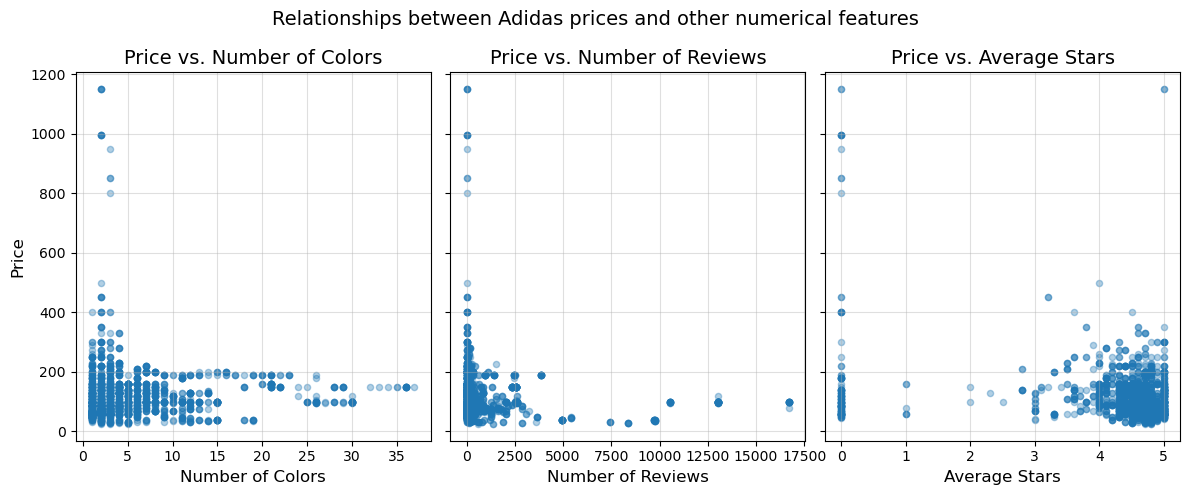

In [176]:
fig, axes = plt.subplots(1, 3, sharey = True, figsize = (12, 5))

fontsize = 14

cols = ["num_colors", "n_reviews", "avg_stars"] 
title_vs_text = ["num_colors", "n_reviews", "avg_stars"]
xlabels = ["Number of Colors", "Number of Reviews", "Average Stars"]

for i, (ax, col, title_vs, xlabel) in enumerate(
            zip(axes, cols, title_vs_text, xlabels) ):

    ax.scatter(adidas[col], adidas["price"], alpha = 0.35, s = 20)
    ax.set_title(f"Price vs. {xlabel}", fontsize = fontsize)
    ax.set_xlabel(xlabel, fontsize = fontsize-2)
    ax.set_ylabel("Price" if i == 0 else None, 
        fontsize = fontsize - 2)
    ax.grid(":", alpha=0.4)

plt.suptitle("Relationships between Adidas prices and other numerical features", 
             fontsize = fontsize)
plt.tight_layout()

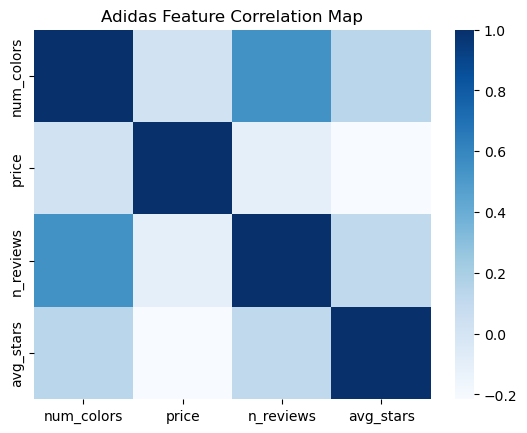

In [177]:
cor = adidas.corr()
sns.heatmap(cor, cmap = 'Blues')
plt.title("Adidas Feature Correlation Map")
plt.show()

## Plot Categorical Variables

In [179]:
adidas.purpose.value_counts(normalize = True) # % of each purpose

Lifestyle                     0.501059
Running                       0.117323
Sportswear                    0.096569
Soccer                        0.047014
Hiking                        0.044049
Basketball                    0.036849
Climbing & Mountain Biking    0.029648
Golf                          0.025837
Baseball                      0.020330
Swim                          0.018636
Training                      0.016942
Tennis                        0.013130
Football                      0.012283
Cycling                       0.005930
Yoga                          0.005083
Weightlifting                 0.003388
Volleyball                    0.002541
Track                         0.002118
Softball                      0.000847
Boxing                        0.000424
Name: purpose, dtype: float64

In [180]:
top_purposes = adidas.purpose.value_counts().head()
top_purposes # top 5 subtitles

Lifestyle     1183
Running        277
Sportswear     228
Soccer         111
Hiking         104
Name: purpose, dtype: int64

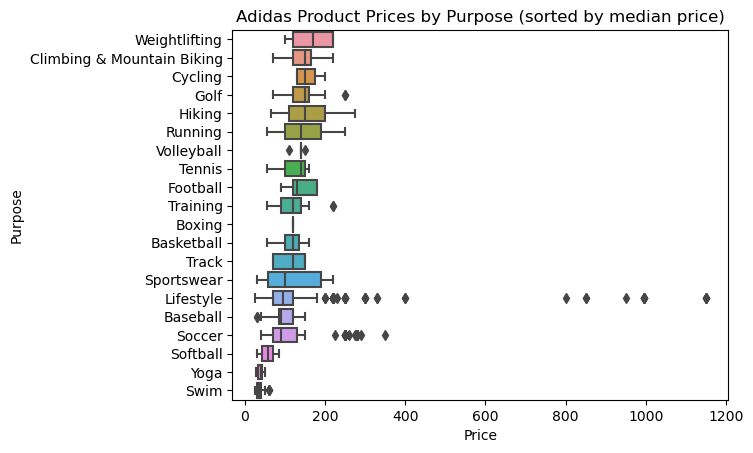

In [188]:
median_price_sorted = adidas.groupby('purpose')['price'].median().sort_values(ascending = False)

# order box plot by median
sns.boxplot(data = adidas, y = 'purpose', x = 'price', 
            order = median_price_sorted.index)
plt.xlabel('Price')
plt.ylabel('Purpose')
plt.title('Adidas Product Prices by Purpose (sorted by median price)')
plt.show()

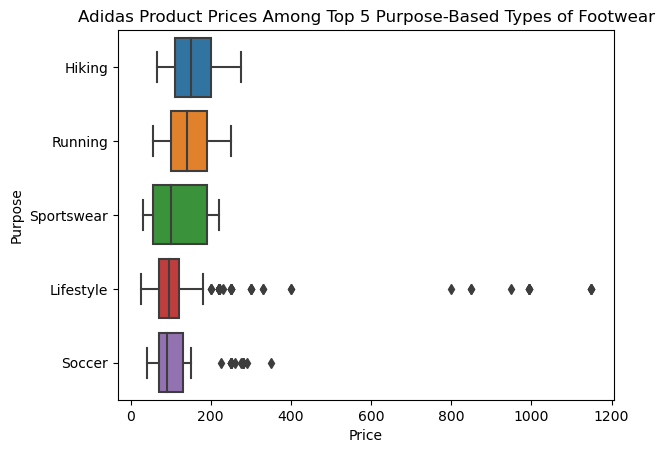

In [189]:
adidas_top_purposes = adidas.loc[adidas.purpose.isin(top_purposes.index.tolist())]
top_purposes_sorted = adidas_top_purposes.groupby('purpose').price.median().sort_values(ascending = False)

# order box plot by median
sns.boxplot(data = adidas_top_purposes, y = 'purpose', x = 'price', 
            order = top_purposes_sorted.index)
plt.xlabel('Price')
plt.ylabel('Purpose')
plt.title('Adidas Product Prices Among Top 5 Purpose-Based Types of Footwear')
plt.show()

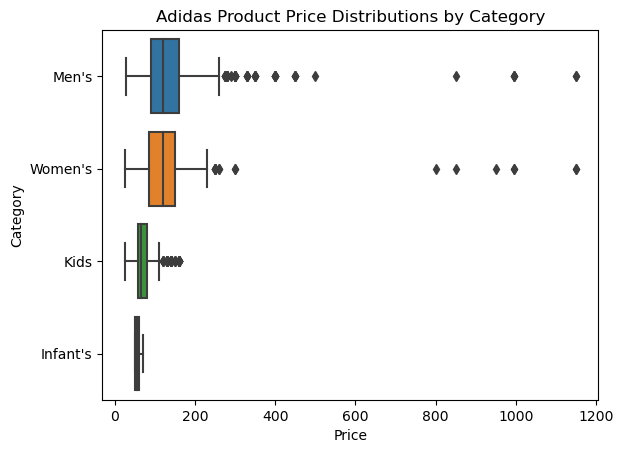

In [190]:
cat_price_median_sorted = adidas.groupby('category').price.median().sort_values(ascending = False)

# order box plot by median
sns.boxplot(data = adidas, y = 'category', x = 'price', 
            order = cat_price_median_sorted.index)
plt.xlabel('Price')
plt.ylabel('Category')
plt.title('Adidas Product Price Distributions by Category')
plt.show()

## Numeric Stats

In [191]:
mean_price = adidas["price"].mean() 
mean_noc = adidas["num_colors"].mean()
std_price = adidas["price"].std() 
std_noc = adidas["num_colors"].std()
print(
    "\n"
    f"The mean price is {mean_price:.4f} \n"
    f"The mean number of colors is {mean_noc:.4f} \n"
    f"The Standard Deviation of price is {std_price:.4f}\n"
    f"The Standard Deviation of number of colors is {std_noc:.4f}"
)


The mean price is 119.7339 
The mean number of colors is 5.6943 
The Standard Deviation of price is 87.6957
The Standard Deviation of number of colors is 6.2613


In [192]:
price_min = adidas["price"].min()
price_max = adidas["price"].max() 
price_range = price_max - price_min 

print(
    f"The range of price for which shoes in our dataset "
    f"is {price_range:,.2f} dolloars. \n\n"
    f"The maximum number of price is {price_max:,.2f}, "
    f"and the minimum is {price_min:,.2f}."
)

The range of price for which shoes in our dataset is 1,125.00 dolloars. 

The maximum number of price is 1,150.00, and the minimum is 25.00.


/Users/runlanlana/micromamba/envs/cs109a/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


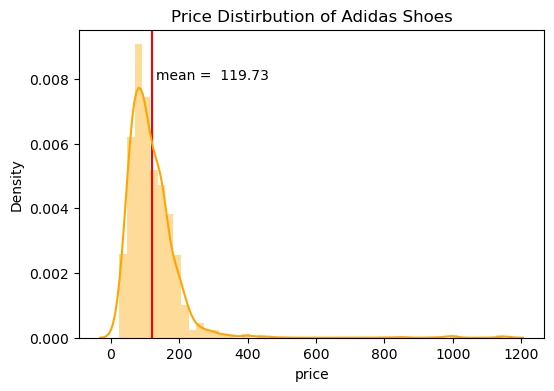

In [193]:
plt.figure(figsize=(6,4))
#ploting the mean
plt.axvline(mean_price, 0, 1, color = 'red')
sns.distplot(adidas['price'], color='orange')
plt.text(mean_price * 1.1, 0.008, f'mean = {mean_price: .2f}', fontsize=10)
plt.title("Price Distirbution of Adidas Shoes")
plt.show()

<Figure size 500x300 with 0 Axes>

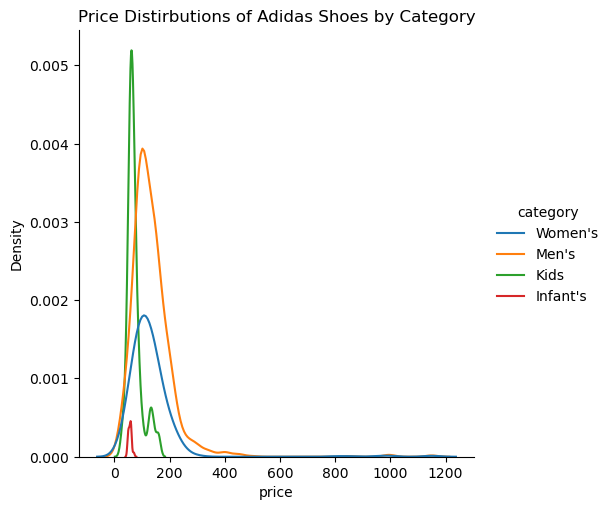

In [203]:
plt.figure(figsize=(5,3))
sns.displot(data = adidas, x = "price", hue = "category", kind = "kde")
plt.title("Price Distirbutions of Adidas Shoes by Category")
plt.show()

# Sentiment Analysis

In [213]:
# copy adidas df to work on
df = adidas.loc[:, ['category', 'description', 'details', 'price']].copy()
df.dropna(inplace = True)

In [214]:
# combine description and details columns
df['description'] = df['description'] + ' ' + df['details']
df.drop(columns = ['details'], inplace = True)

In [215]:
analyzer = SIA()
# using sentiment analysis and get negative, neutral, poisitve scores on columns "rating"
df['rating'] = df['description'].apply(analyzer.polarity_scores)
df.head()

,category,description,price,rating
0,Women's,You'll want these adidas running shoes the nex...,65.0,"{'neg': 0.023, 'neu': 0.864, 'pos': 0.113, 'co..."
1,Men's,"One shoe to rule them all. School, work or kic...",130.0,"{'neg': 0.0, 'neu': 0.835, 'pos': 0.165, 'comp..."
2,Women's,"Comfort is key, whether you're racing to catch...",90.0,"{'neg': 0.024, 'neu': 0.867, 'pos': 0.108, 'co..."
3,Men's,Classics for a reason. These adidas slides are...,40.0,"{'neg': 0.0, 'neu': 0.805, 'pos': 0.195, 'comp..."
4,Men's,It doesn't really matter whether or not a run ...,85.0,"{'neg': 0.018, 'neu': 0.938, 'pos': 0.044, 'co..."


In [216]:
# change each keys/values of dictionary in column rating, to be the new columns of dataframe
df_sentiment = pd.concat([df.drop(['rating'], axis=1), df['rating'].apply(pd.Series)], axis=1)
df_sentiment.head()

,category,description,price,neg,neu,pos,compound
0,Women's,You'll want these adidas running shoes the nex...,65.0,0.023,0.864,0.113,0.8316
1,Men's,"One shoe to rule them all. School, work or kic...",130.0,0.000,0.835,0.165,0.9118
2,Women's,"Comfort is key, whether you're racing to catch...",90.0,0.024,0.867,0.108,0.7717
3,Men's,Classics for a reason. These adidas slides are...,40.0,0.000,0.805,0.195,0.9538
4,Men's,It doesn't really matter whether or not a run ...,85.0,0.018,0.938,0.044,0.4232


In [217]:
df_sentiment['score'] = np.where(df_sentiment['compound'] < 0, 'negative', 'positive')
df_sentiment.head()

,category,description,price,neg,neu,pos,compound,score
0,Women's,You'll want these adidas running shoes the nex...,65.0,0.023,0.864,0.113,0.8316,positive
1,Men's,"One shoe to rule them all. School, work or kic...",130.0,0.000,0.835,0.165,0.9118,positive
2,Women's,"Comfort is key, whether you're racing to catch...",90.0,0.024,0.867,0.108,0.7717,positive
3,Men's,Classics for a reason. These adidas slides are...,40.0,0.000,0.805,0.195,0.9538,positive
4,Men's,It doesn't really matter whether or not a run ...,85.0,0.018,0.938,0.044,0.4232,positive


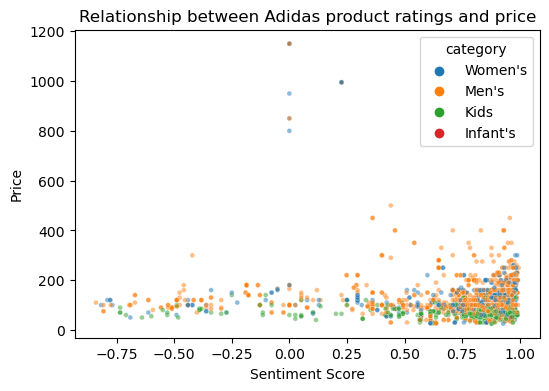

In [221]:
plt.figure(figsize = (6,4))
sns.scatterplot(data = df_sentiment, x = 'compound', y = "price",
                hue = 'category', alpha = 0.5, s = 12)
plt.xlabel("Sentiment Score")
plt.ylabel("Price")
plt.title("Relationship between Adidas product ratings and price")
plt.show()

**Only consider the subset that has nagative score description**

In [222]:
positive_des = (df_sentiment['score'] == 'positive').sum()
negative_des = (df_sentiment['score'] == 'negative').sum()
print(f"There are {positive_des} positive descriptions and {negative_des} negative descriptions.")

There are 2229 positive descriptions and 135 negative descriptions.


In [223]:
neg = df_sentiment[df_sentiment['score']=='negative']
neg.head()

,category,description,price,neg,neu,pos,compound,score
9,Women's,These adidas sneakers are tasteful and minimal...,60.0,0.076,0.882,0.042,-0.4902,negative
31,Men's,"When worlds collide, magic happens. These adid...",70.0,0.024,0.976,0.000,-0.0772,negative
37,Women's,Millions of people have laced into adidas Stan...,100.0,0.078,0.887,0.036,-0.8176,negative
47,Men's,"Remember the epic shots, close games and fierc...",110.0,0.026,0.952,0.022,-0.0772,negative
84,Women's,"In the 2000s, the internet was slow and phones...",100.0,0.111,0.825,0.064,-0.7684,negative


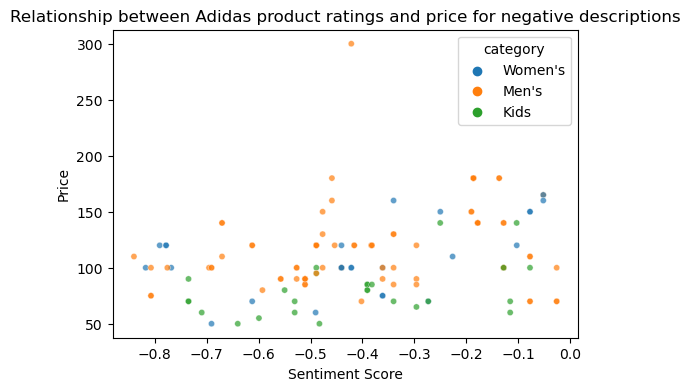

In [228]:
plt.figure(figsize = (6,4))
# plt.scatter(neg['compound'], neg["price"], alpha = 0.5, s = 20)
sns.scatterplot(data = neg, x = 'compound', y = "price",
                hue = 'category', alpha = 0.7, s = 20)
plt.xlabel("Sentiment Score")
plt.ylabel("Price")
plt.title("Relationship between Adidas product ratings and price for negative descriptions")
plt.show()

This approach is not appropriate since assigning the description columns as a numerical varialbe does not help in telling the pattern of prices.

# NLP Analysis

Combine `description` and `details` columns

In [239]:
df = adidas.loc[:, ['title', 'category', 'purpose', 'description', 'details', 'price']].copy()  # subset
# df_desc.fillna('', inplace = True)
df['text'] = df['title'].str.cat(df['category'], sep = '; ', na_rep = '')
df['text'] = df['text'].str.cat(df['purpose'], sep = '; ', na_rep = '')
df['text'] = df['text'].str.cat(df['description'], sep = '; ', na_rep = '')
df['text'] = df['text'].str.cat(df['details'], sep = '; ', na_rep = '')

df = df[['text', 'price']]
df.dropna(inplace = True)  # dropna
df.head()

,text,price
0,Start Your Run Shoes; Women's; Running; You'll...,65.0
1,NMD_R1 Shoes; Men's; Lifestyle; One shoe to ru...,130.0
2,Edge Lux Shoes; Women's; Training; Comfort is ...,90.0
3,Adilette Comfort Slides; Men's; Sportswear; Cl...,40.0
4,Fluidflow 2.0 Shoes; Men's; Sportswear; It doe...,85.0


In [240]:
df['text'] = df['text'].str.lower()
df['text'] = df['text'].str.replace(r'([^\w\s]|_)+', '', regex = True)
df['text'] = df['text'].str.split()
stopwords = pd.read_csv('data/stopwords_nopunc.csv').stopwords.values
df['text'] = df['text'].apply(lambda x: [str(w) for w in x if w not in stopwords])
vocab_counts = df['text'].explode().value_counts()
min_count = 5
vocab = [k for k,v in vocab_counts.items() if v >= 5]
print(f"There are {len(vocab):,} unique words in a reduced, corpus vocabulary for Adidas dataset.")

There are 2,758 unique words in a reduced, corpus vocabulary for Adidas dataset.


In [241]:
# vectorization methods
df['text'] = df['text'].apply(lambda x: [w for w in x if w in vocab])
counts = df['text'].apply(Counter).to_list()
bow_df = pd.DataFrame(counts).fillna(0).astype(int)
bow_df

,start,run,shoes,womens,running,want,adidas,next,time,step,...,purehustle,primeweave,hellcat,cliplesscompatible,leatherfree,triplelayer,extension,sixcleat,innings,agile
0,1,1,2,1,2,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,0,0,2,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,2,1,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1,2,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2381,0,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2382,0,0,0,0,0,0,3,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2383,0,0,2,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2384,0,0,2,0,1,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0


bin price into 5 discrete brackets

In [242]:
df.reset_index(drop = True, inplace = True)
df_processed = pd.concat([bow_df, df['price']], axis = 1)

In [243]:
# check default percentile cut
pd.cut(df_processed.price, bins = 5).value_counts()

(23.875, 250.0]    2322
(250.0, 475.0]       50
(925.0, 1150.0]      10
(700.0, 925.0]        3
(475.0, 700.0]        1
Name: price, dtype: int64

The above cuts are extremely imbalanced. Manual cuts are performed based on the discretion

In [244]:
# make everything > 200 its only bin
df_processed['is_above_200'] = df_processed.price > 200
df_processed['bracket'] = df_processed.price > 200
df_processed['bracket'].replace(True, 'above_200', inplace=True)
df_processed['bracket'].replace(False, np.nan, inplace=True)

In [245]:
# use default binning for <= 200
binned_low_brackets = pd.cut(df_processed.loc[~df_processed['is_above_200'], 'price'], 
                             bins = 4)
# combine the bins
df_processed['bracket'] = df_processed['bracket'].fillna(binned_low_brackets)
df_processed['price'] = df_processed['bracket']  # .astype('string')
print("Price brackets:")
print(df_processed['price'].value_counts())
print(df_processed['price'].value_counts(normalize = True))

Price brackets:
(68.75, 112.5]     886
(112.5, 156.25]    532
(24.825, 68.75]    473
(156.25, 200.0]    343
above_200          152
Name: price, dtype: int64
(68.75, 112.5]     0.371333
(112.5, 156.25]    0.222967
(24.825, 68.75]    0.198240
(156.25, 200.0]    0.143755
above_200          0.063705
Name: price, dtype: float64


In [246]:
# clean up
df_processed.drop(['is_above_200', 'bracket'], axis = 1, inplace=True)
df_processed.head()

,start,run,shoes,womens,running,want,adidas,next,time,step,...,primeweave,hellcat,cliplesscompatible,leatherfree,triplelayer,extension,sixcleat,innings,agile,price
0,1,1,2,1,2,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,"(24.825, 68.75]"
1,0,0,2,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,"(112.5, 156.25]"
2,0,0,2,1,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,"(68.75, 112.5]"
3,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,"(24.825, 68.75]"
4,0,1,2,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,"(68.75, 112.5]"


# Word Feature Importance with Naive Bayes

In [247]:
df_processed1 = df_processed.copy()
df_processed1['price'] = df_processed1['price'].astype('string')

In [248]:
X_train, X_test, y_train, y_test = train_test_split(df_processed1.drop('price', axis=1),
                                                    df_processed1['price'], 
                                                    test_size=0.2, 
                                                    random_state=109)

In [249]:
mnb = MultinomialNB().fit(X_train, y_train)
mnb.score(X_test, y_test)

0.7740585774058577

***Feature importance for each class:***

In [250]:
# 5 brackets
y_train.value_counts(sort = False)

(68.75, 112.5]     717
(112.5, 156.25]    416
(24.825, 68.75]    387
(156.25, 200.0]    266
above_200          122
Name: price, dtype: Int64

In [251]:
# get most predictive words for each class (bracket 1 and bracket 3)
feat_imp_list = []

for i in range(len(mnb.classes_)):
    class_prob_sorted = mnb.feature_log_prob_[i, :].argsort()[::-1]
    top_pred_words = np.take(bow_df.columns, class_prob_sorted[:])
    feat_imp_list.append(top_pred_words)

**The top 10 most predictive words for each price bracket:**

In [252]:
# prettify list to df
feat_imp_df = pd.DataFrame(np.array(feat_imp_list).T, columns = mnb.classes_)
feat_imp_df = feat_imp_df.loc[:, y_train.value_counts(sort=False).index]  # reorder columns
feat_imp_df.head(10)

,"(68.75, 112.5]","(112.5, 156.25]","(24.825, 68.75]","(156.25, 200.0]",above_200
0,product,upper,product,upper,product
1,upper,product,upper,product,upper
2,shoes,shoes,recycled,shoes,adidas
3,recycled,outsole,shoes,50,shoes
4,outsole,recycled,outsole,midsole,outsole
5,content,50,content,adidas,midsole
6,color,midsole,adidas,recycled,rubber
7,adidas,adidas,color,outsole,color
8,code,color,50,boost,imported
9,imported,content,code,rubber,code


# Word Feature Importance with Random Forest

In [265]:
rf = RandomForestClassifier(n_estimators = 300, max_depth = 18,
                            min_samples_leaf = 4, random_state = 0).fit(X_train, y_train)
random_forest_train_score = rf.score(X_train, y_train)
random_forest_test_score = rf.score(X_test, y_test)

In [266]:
print(f"random forest training score is {random_forest_train_score}")
print(f"random forest test score is {random_forest_test_score}")

random forest training score is 0.8448637316561844
random forest test score is 0.7531380753138075


In [267]:
top_predictors_rf = df_processed.columns[[dtree.tree_.feature[0] for dtree in rf.estimators_]]
top_predictors_rf = pd.Series(top_predictors_rf).value_counts().sort_values(ascending = False)
top_predictors_rf = pd.DataFrame(top_predictors_rf, columns = ['Count'])
print("Top Predictor Counts - Random Forest")
display(top_predictors_rf)

Top Predictor Counts - Random Forest


,Count
slides,9
footbed,8
adilette,8
slipon,7
primeknit,7
...,...
basketball,1
least,1
sport,1
mccartney,1


In [268]:
# def plot_feature_importance(importance, names, imp_type):
#     feature_importance = np.array(importance)
#     feature_names = np.array(names)

#     data = {'feature_names': feature_names, 'feature_importance': feature_importance}
#     fi_df = pd.DataFrame(data)
#     fi_df.sort_values(by = ['feature_importance'], ascending = False, inplace = True))
    
#     plt.figure(figsize=(10,8))
#     sns.barplot(x = fi_df['feature_importance'], y = fi_df['feature_names'])
#     #Add chart labels
#     plt.title(imp_type + 'Feature Importance')
#     plt.xlabel('Feature Importance')
#     plt.ylabel('Feature Names')
    
    
# Helper function to plot the feature importance (MDI & Perm)
def plot_feature_importance(mdi_imp, perm_imp, colnames):
    plt.xkcd(scale=0.3,randomness=0.6)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (14, 6))

    mdi_importance_sorted_idx = np.argsort(mdi_imp)
    mdi_indices = np.arange(0, len(mdi_imp)) +0.5

    ax1.barh(mdi_indices, result1.importances_mean[mdi_importance_sorted_idx], 
              height = 0.7, color = '#B2D7D0')
    ax1.set_yticks(mdi_indices)
    ax1.set_yticklabels(colnames[mdi_importance_sorted_idx], fontsize = 12)
    ax1.set_ylim((0, len(mdi_imp)))
    ax1.set_xlabel("MDI-Based Feature Importance", fontsize = 16)


    perm_importance_sorted_idx = np.argsort(perm_imp)
    perm_indices = np.arange(0, len(perm_imp)) +0.5
    # difference = perm_imp['importances_mean'] - perm_imp['importances_mean']
    # difference = difference[perm_importance_sorted_idx]

    ax2.barh(perm_indices, perm_imp[perm_importance_sorted_idx], 
              height = 0.7, color = '#EFAEA4')
   
    ax2.set_yticks(perm_indices)
    ax2.set_yticklabels(X.columns[perm_importance_sorted_idx], fontsize = 12)
    ax2.set_ylim((0, len(perm_imp)))
    ax2.set_xlabel("Permutation Feature Importance", fontsize = 16)
    maxlim = max(perm_imp)
    ax2.set_xlim(0, maxlim + 0.015)
    ax1.set_title("MDI-Based Importance", fontsize = 18)
    ax2.set_title("Permutation Importance", fontsize = 18)
    fig.tight_layout()
    plt.show()

**MDI-based and permutation feature importances**

In [ ]:
# TODO: X_train cols too big
perm_imp = permutation_importance(rf, X_train, y_train)['importances_mean']
plot_feature_importance(rf.feature_importances_, perm_imp, list(X_train.columns))
# plot_feature_importance(rf.feature_importances_, X_train.columns, 'MDI-Based')

In [ ]:
# plot_feature_importance(permutation_importance(rf, X_train, y_train), X_train.columns, 'Permutation')

# TFIDF on BOW

Term frequency (TF) = (Number of Occurrences of a word)/(Total words in the document)

**TF-IDF on text column**

In [309]:
df = adidas.loc[:, ['title', 'category', 'purpose', 'description', 'details', 'price']].copy()  # subset
df['text'] = df['title'].str.cat(df['category'], sep = '; ', na_rep = '')
df['text'] = df['text'].str.cat(df['purpose'], sep = '; ', na_rep = '')
df['text'] = df['text'].str.cat(df['description'], sep = '; ', na_rep = '')
df['text'] = df['text'].str.cat(df['details'], sep = '; ', na_rep = '')
df = df[['text', 'price']]
df.dropna(inplace = True)  # dropna
df.head()

tfidf_vec = TfidfVectorizer(sublinear_tf = True, smooth_idf = True)
tfidf_mat = tfidf_vec.fit_transform(df['text'])
df_tfidf = pd.DataFrame(tfidf_mat.todense(), 
                        columns = tfidf_vec.get_feature_names_out())
df_tfidf.head()

,00s,019000,019228,034563,036516,10,100k,10k,10km,11,...,znsored,zntasy,zone,zoned,zones,zoom,zooming,zooms,zx,zx22
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [322]:
df_tfidf.to_csv("data/adidas_tfidf_mat.csv")

***Calculate each word's TF-IDF score relative to each of the 5 price brackets.***

In [274]:
df_docs = df_processed.groupby('price').sum()
df_docs

,start,run,shoes,womens,running,want,adidas,next,time,step,...,purehustle,primeweave,hellcat,cliplesscompatible,leatherfree,triplelayer,extension,sixcleat,innings,agile
price,,,,,,,,,,,,,,,,,,,,,
"(24.825, 68.75]",7,64,655,67,134,10,505,4,41,56,...,2,0,0,0,0,0,0,0,5,0
"(68.75, 112.5]",20,110,1601,244,240,19,907,22,61,150,...,8,0,0,0,0,0,6,6,0,0
"(112.5, 156.25]",11,35,1063,173,218,20,581,36,57,92,...,0,0,2,1,0,0,0,0,3,0
"(156.25, 200.0]",17,76,691,100,276,24,542,31,70,92,...,0,6,8,4,0,0,0,0,0,10
above_200,9,55,214,46,116,3,286,9,15,34,...,0,0,0,0,8,8,0,0,0,0


***Transform BOW representation into list of documents:***

In [275]:
docs = []  # documents - a list of strings (unique words concatenated for each bracket)

for bracket in df_docs.index:
    row = df_docs.loc[bracket, :]
    # logic: replace nonzero with NA; fill NA with column names; remove unfilled values (counts)
    row[row != 0] = np.nan
    doc = row.astype('string').fillna(row.index.to_series())
    doc = doc.loc[~doc.str.match('.+\..+')].tolist()
    doc = ' '.join(doc)
    docs.append(doc)

# docs[4]  # concatenated unique words for last price bracket

***TF-IDF of each word relative to each price bracket***

In [276]:
corpus = docs
vectorizer = TfidfVectorizer(use_idf=True)
tfIdf = vectorizer.fit_transform(corpus)
df_tfidf_by_price = pd.DataFrame(tfIdf.T.todense(), 
                        index = vectorizer.get_feature_names_out(), 
                        columns = df_docs.index)

df_tfidf_by_price

price,"(24.825, 68.75]","(68.75, 112.5]","(112.5, 156.25]","(156.25, 200.0]",above_200
10,0.019162,0.015362,0.016381,0.019837,0.024846
102,0.000000,0.026010,0.000000,0.033586,0.000000
105,0.000000,0.026010,0.000000,0.033586,0.000000
10k,0.000000,0.018163,0.019368,0.023453,0.029376
11,0.000000,0.000000,0.023023,0.027880,0.034920
...,...,...,...,...,...
znchill,0.000000,0.000000,0.034378,0.000000,0.000000
zntasy,0.000000,0.032239,0.000000,0.000000,0.000000
zone,0.019162,0.015362,0.016381,0.019837,0.024846
zones,0.000000,0.018163,0.019368,0.023453,0.029376


***TF-IDF should give us some idea of words that are truly unique to each bracket:***

In [277]:
# check out first bracket's words with top 10 TF-IDF
df_tfidf_by_price.iloc[:, 0].sort_values(ascending = False).head(10)

tnd            0.040213
scurry         0.040213
vulcraid3r     0.040213
locker         0.040213
pool           0.040213
poolside       0.040213
seem           0.040213
children       0.040213
postworkout    0.040213
channel        0.040213
Name: (24.825, 68.75], dtype: float64

In [278]:
# check out first bracket's words with bottom 10 TF-IDF
df_tfidf_by_price.iloc[:, 0].sort_values(ascending = True).head(10)

zx            0.0
fly           0.0
fluidflow     0.0
fluid         0.0
refresh       0.0
reimagine     0.0
reimagines    0.0
floating      0.0
foam          0.0
flipped       0.0
Name: (24.825, 68.75], dtype: float64

In [280]:
df_tfidf_by_price.head()

price,"(24.825, 68.75]","(68.75, 112.5]","(112.5, 156.25]","(156.25, 200.0]",above_200
10,0.019162,0.015362,0.016381,0.019837,0.024846
102,0.000000,0.026010,0.000000,0.033586,0.000000
105,0.000000,0.026010,0.000000,0.033586,0.000000
10k,0.000000,0.018163,0.019368,0.023453,0.029376
11,0.000000,0.000000,0.023023,0.027880,0.034920


## Prep Data for Advanced Modeling

In [310]:
# drop NA based on col description
df = adidas.dropna(subset = ['description']).copy()
df.head(1)

,title,subtitle,num_colors,url,price,reduced_price,description,details,colors,n_reviews,avg_stars,product_code,category,purpose
0,Start Your Run Shoes,Women's Running,4.0,/us/start-your-run-shoes/GY9233.html,65.0,$33,You'll want these adidas running shoes the nex...,Regular fit; Lace closure; Textile upper; LIGH...,Dash Grey / Matte Silver / Core Black,5.0,4.8,GY9233,Women's,Running


In [311]:
# subtitle categorical feature
purpose_freq = df.purpose.value_counts()
purpose_freq

Lifestyle                     1176
Running                        277
Sportswear                     225
Soccer                         111
Hiking                         104
Basketball                      83
Climbing & Mountain Biking      69
Golf                            61
Baseball                        45
Swim                            44
Training                        40
Tennis                          31
Football                        26
Cycling                         14
Yoga                            12
Weightlifting                    8
Volleyball                       6
Track                            5
Softball                         2
Boxing                           1
Name: purpose, dtype: int64

In [312]:
# clean subtitle up - counts < 30, make them into an 'other' category
df.loc[df.purpose.isin(purpose_freq[purpose_freq < 30].index), 'purpose'] = 'other'

### Other non text features

In [313]:
# subset
df_sub = df.loc[:, ['num_colors', 'n_reviews', 'avg_stars', 'category', 'purpose']].copy()
df_sub.head(3)

,num_colors,n_reviews,avg_stars,category,purpose
0,4.0,5.0,4.8,Women's,Running
1,1.0,131.0,4.6,Men's,Lifestyle
2,5.0,191.0,4.0,Women's,Training


In [314]:
# dummy
df_sub = pd.get_dummies(df_sub)
df_sub.head(3)

,num_colors,n_reviews,avg_stars,category_Infant's,category_Kids,category_Men's,category_Women's,purpose_Baseball,purpose_Basketball,purpose_Climbing & Mountain Biking,purpose_Golf,purpose_Hiking,purpose_Lifestyle,purpose_Running,purpose_Soccer,purpose_Sportswear,purpose_Swim,purpose_Tennis,purpose_Training,purpose_other
0,4.0,5.0,4.8,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
1,1.0,131.0,4.6,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0
2,5.0,191.0,4.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0


In [315]:
# prefix all non-text features - to distinguish from BOW words
df_sub.columns = ['feature_' + col for col in df_sub.columns]
df_sub.head(3)

,feature_num_colors,feature_n_reviews,feature_avg_stars,feature_category_Infant's,feature_category_Kids,feature_category_Men's,feature_category_Women's,feature_purpose_Baseball,feature_purpose_Basketball,feature_purpose_Climbing & Mountain Biking,feature_purpose_Golf,feature_purpose_Hiking,feature_purpose_Lifestyle,feature_purpose_Running,feature_purpose_Soccer,feature_purpose_Sportswear,feature_purpose_Swim,feature_purpose_Tennis,feature_purpose_Training,feature_purpose_other
0,4.0,5.0,4.8,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
1,1.0,131.0,4.6,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0
2,5.0,191.0,4.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0


### Concatenate original features with BOW

In [319]:
df_model = pd.concat([df_processed[['price']], df_sub, df_tfidf], axis = 1)

In [320]:
df_model.rename({'price': 'target_price'}, axis = 1, inplace = True)

In [321]:
df_model.head()

,target_price,feature_num_colors,feature_n_reviews,feature_avg_stars,feature_category_Infant's,feature_category_Kids,feature_category_Men's,feature_category_Women's,feature_purpose_Baseball,feature_purpose_Basketball,...,znsored,zntasy,zone,zoned,zones,zoom,zooming,zooms,zx,zx22
0,"(24.825, 68.75]",4.0,5.0,4.8,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,"(112.5, 156.25]",1.0,131.0,4.6,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,"(68.75, 112.5]",5.0,191.0,4.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,"(24.825, 68.75]",19.0,9735.0,4.7,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,"(68.75, 112.5]",3.0,866.0,4.6,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### convert `target_price` into integer

In [77]:
# the original labels
df_model['target_price'].value_counts()

(68.75, 112.5]     878
(112.5, 156.25]    529
(24.825, 68.75]    467
(156.25, 200.0]    344
above_200          150
Name: target_price, dtype: int64

In [78]:
# label to int
df_model['target_price'] = df_model['target_price'].astype('category').cat.codes

In [79]:
df_model.head()

,target_price,feature_num_colors,feature_n_reviews,feature_avg_stars,feature_category_Baseball,feature_category_Basketball,feature_category_Children Shoe,feature_category_Essentials,feature_category_Five Ten,feature_category_Golf,...,empty,primeweave,hellcat,cliplesscompatible,leatherfree,triplelayer,extension,sixcleat,innings,agile
0,0,4.0,5.0,4.8,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,1.0,131.0,4.6,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,5.0,191.0,4.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,19.0,9735.0,4.7,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,3.0,866.0,4.6,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Note the structure:

- target: `target_price`
- non-text features: `feature_xxx` - 3 numeric, 1 categorical (dummified category)
- text features from description: put at the end of the df

**Save final df for further modeling**

In [80]:
df_model.to_csv('data/adidas_model.csv', index=False)

# Classification Model

In [ ]:
df_model = pd.read_csv("data/adidas_model.csv")
df_model.head(3)

In [114]:
est_df = df_model.loc[:,~df_model.columns.duplicated()]
X = est_df.drop('target_price', axis=1)
Y = est_df.iloc[:, 0].values

seed = 7
test_size = 0.33
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)

# fit model no training data
model = XGBClassifier()
model.fit(X_train, y_train)
print(model)

# make predictions for test data
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', ...)
Accuracy: 88.87%


In [ ]:
print(classification_report(y_test, y_pred, target_names = ??))